In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
from loguru import logger


PROJECT_ROOT = Path.cwd().parent  # or Path(__file__).parent.parent

train_df = pd.read_csv(PROJECT_ROOT / "data" / "train.csv", parse_dates=["date"])
test_df = pd.read_csv(PROJECT_ROOT / "data" / "test.csv", parse_dates=["date"])

# Imputing values

In [18]:
gdp_per_capita_df = pd.read_csv(PROJECT_ROOT / "data" / "gdp_per_capita.csv")

years =  ["2010", "2011", "2012", "2013", "2014", "2015", "2016", "2017", "2018", "2019", "2020"]
gdp_per_capita_filtered_df = gdp_per_capita_df.loc[gdp_per_capita_df["Country Name"].isin(train_df["country"].unique()), ["Country Name"] + years].set_index("Country Name")
gdp_per_capita_filtered_df["2010_ratio"] = gdp_per_capita_filtered_df["2010"] / gdp_per_capita_filtered_df.sum()["2010"]
for year in years:
    gdp_per_capita_filtered_df[f"{year}_ratio"] = gdp_per_capita_filtered_df[year] / gdp_per_capita_filtered_df.sum()[year]
gdp_per_capita_filtered_ratios_df = gdp_per_capita_filtered_df[[i+"_ratio" for i in years]]
gdp_per_capita_filtered_ratios_df.columns = [int(i) for i in years]
gdp_per_capita_filtered_ratios_df = gdp_per_capita_filtered_ratios_df.unstack().reset_index().rename(columns = {"level_0": "year", 0: "ratio", "Country Name": "country"})
gdp_per_capita_filtered_ratios_df['year'] = pd.to_datetime(gdp_per_capita_filtered_ratios_df['year'], format='%Y')

In [19]:
gdp_per_capita_filtered_ratios_df["year"] = gdp_per_capita_filtered_ratios_df["year"].dt.year
train_df_imputed = train_df.copy()
print(f"Missing values remaining: {train_df_imputed['num_sold'].isna().sum()}")

train_df_imputed["year"] = train_df_imputed["date"].dt.year
for year in train_df_imputed["year"].unique():
    # Impute Time Series 1 (Canada, Discount Stickers, Holographic Goose)
    target_ratio = gdp_per_capita_filtered_ratios_df.loc[(gdp_per_capita_filtered_ratios_df["year"] == year) & (gdp_per_capita_filtered_ratios_df["country"] == "Norway"), "ratio"].values[0] # Using Norway as should have the best precision
    current_raito = gdp_per_capita_filtered_ratios_df.loc[(gdp_per_capita_filtered_ratios_df["year"] == year) & (gdp_per_capita_filtered_ratios_df["country"] == "Canada"), "ratio"].values[0]
    ratio_can = current_raito / target_ratio
    train_df_imputed.loc[(train_df_imputed["country"] == "Canada") & (train_df_imputed["store"] == "Discount Stickers") & (train_df_imputed["product"] == "Holographic Goose") & (train_df_imputed["year"] == year), "num_sold"] = (train_df_imputed.loc[(train_df_imputed["country"] == "Norway") & (train_df_imputed["store"] == "Discount Stickers") & (train_df_imputed["product"] == "Holographic Goose") & (train_df_imputed["year"] == year), "num_sold"] * ratio_can).values
    
    # Impute Time Series 2 (Only Missing Values)
    current_ts =  train_df_imputed.loc[(train_df_imputed["country"] == "Canada") & (train_df_imputed["store"] == "Premium Sticker Mart") & (train_df_imputed["product"] == "Holographic Goose") & (train_df_imputed["year"] == year)]
    missing_ts_dates = current_ts.loc[current_ts["num_sold"].isna(), "date"]
    train_df_imputed.loc[(train_df_imputed["country"] == "Canada") & (train_df_imputed["store"] == "Premium Sticker Mart") & (train_df_imputed["product"] == "Holographic Goose") & (train_df_imputed["year"] == year) & (train_df_imputed["date"].isin(missing_ts_dates)), "num_sold"] = (train_df_imputed.loc[(train_df_imputed["country"] == "Norway") & (train_df_imputed["store"] == "Premium Sticker Mart") & (train_df_imputed["product"] == "Holographic Goose") & (train_df_imputed["year"] == year) & (train_df_imputed["date"].isin(missing_ts_dates)), "num_sold"] * ratio_can).values

    # Impute Time Series 3 (Only Missing Values)
    current_ts =  train_df_imputed.loc[(train_df_imputed["country"] == "Canada") & (train_df_imputed["store"] == "Stickers for Less") & (train_df_imputed["product"] == "Holographic Goose") & (train_df_imputed["year"] == year)]
    missing_ts_dates = current_ts.loc[current_ts["num_sold"].isna(), "date"]
    train_df_imputed.loc[(train_df_imputed["country"] == "Canada") & (train_df_imputed["store"] == "Stickers for Less") & (train_df_imputed["product"] == "Holographic Goose") & (train_df_imputed["year"] == year) & (train_df_imputed["date"].isin(missing_ts_dates)), "num_sold"] = (train_df_imputed.loc[(train_df_imputed["country"] == "Norway") & (train_df_imputed["store"] == "Stickers for Less") & (train_df_imputed["product"] == "Holographic Goose") & (train_df_imputed["year"] == year) & (train_df_imputed["date"].isin(missing_ts_dates)), "num_sold"] * ratio_can).values
    
    # Impute Time Series 4 (Kenya, Discount Stickers, Holographic Goose)
    current_raito = gdp_per_capita_filtered_ratios_df.loc[(gdp_per_capita_filtered_ratios_df["year"] == year) & (gdp_per_capita_filtered_ratios_df["country"] == "Kenya"), "ratio"].values[0]
    ratio_ken = current_raito / target_ratio
    train_df_imputed.loc[(train_df_imputed["country"] == "Kenya") & (train_df_imputed["store"] == "Discount Stickers") & (train_df_imputed["product"] == "Holographic Goose") & (train_df_imputed["year"] == year), "num_sold"] = (train_df_imputed.loc[(train_df_imputed["country"] == "Norway") & (train_df_imputed["store"] == "Discount Stickers") & (train_df_imputed["product"] == "Holographic Goose")& (train_df_imputed["year"] == year), "num_sold"] * ratio_ken).values

    # Impute Time Series 5 (Only Missing Values)
    current_ts = train_df_imputed.loc[(train_df_imputed["country"] == "Kenya") & (train_df_imputed["store"] == "Premium Sticker Mart") & (train_df_imputed["product"] == "Holographic Goose") & (train_df_imputed["year"] == year)]
    missing_ts_dates = current_ts.loc[current_ts["num_sold"].isna(), "date"]
    train_df_imputed.loc[(train_df_imputed["country"] == "Kenya") & (train_df_imputed["store"] == "Premium Sticker Mart") & (train_df_imputed["product"] == "Holographic Goose") & (train_df_imputed["year"] == year) & (train_df_imputed["date"].isin(missing_ts_dates)), "num_sold"] = (train_df_imputed.loc[(train_df_imputed["country"] == "Norway") & (train_df_imputed["store"] == "Premium Sticker Mart") & (train_df_imputed["product"] == "Holographic Goose") & (train_df_imputed["year"] == year) & (train_df_imputed["date"].isin(missing_ts_dates)), "num_sold"] * ratio_ken).values

    # Impute Time Series 6 (Only Missing Values)
    current_ts = train_df_imputed.loc[(train_df_imputed["country"] == "Kenya") & (train_df_imputed["store"] == "Stickers for Less") & (train_df_imputed["product"] == "Holographic Goose") & (train_df_imputed["year"] == year)]
    missing_ts_dates = current_ts.loc[current_ts["num_sold"].isna(), "date"]
    train_df_imputed.loc[(train_df_imputed["country"] == "Kenya") & (train_df_imputed["store"] == "Stickers for Less") & (train_df_imputed["product"] == "Holographic Goose") & (train_df_imputed["year"] == year) & (train_df_imputed["date"].isin(missing_ts_dates)), "num_sold"] = (train_df_imputed.loc[(train_df_imputed["country"] == "Norway") & (train_df_imputed["store"] == "Stickers for Less") & (train_df_imputed["product"] == "Holographic Goose") & (train_df_imputed["year"] == year) & (train_df_imputed["date"].isin(missing_ts_dates)), "num_sold"] * ratio_ken).values

    # Impute Time Series 7 (Only Missing Values)
    current_ts = train_df_imputed.loc[(train_df_imputed["country"] == "Kenya") & (train_df_imputed["store"] == "Discount Stickers") & (train_df_imputed["product"] == "Kerneler") & (train_df_imputed["year"] == year)]
    missing_ts_dates = current_ts.loc[current_ts["num_sold"].isna(), "date"]
    train_df_imputed.loc[(train_df_imputed["country"] == "Kenya") & (train_df_imputed["store"] == "Discount Stickers") & (train_df_imputed["product"] == "Kerneler") & (train_df_imputed["year"] == year) & (train_df_imputed["date"].isin(missing_ts_dates)), "num_sold"] = (train_df_imputed.loc[(train_df_imputed["country"] == "Norway") & (train_df_imputed["store"] == "Discount Stickers") & (train_df_imputed["product"] == "Kerneler") & (train_df_imputed["year"] == year) & (train_df_imputed["date"].isin(missing_ts_dates)), "num_sold"] * ratio_ken).values
    
print(f"Missing values remaining: {train_df_imputed['num_sold'].isna().sum()}")


Missing values remaining: 8871
Missing values remaining: 2


In [20]:
missing_rows = train_df_imputed.loc[train_df_imputed["num_sold"].isna()]

train_df_imputed.loc[train_df_imputed["id"] == 23719, "num_sold"] = 4
train_df_imputed.loc[train_df_imputed["id"] == 207003, "num_sold"] = 195

print(f"Missing values remaining: {train_df_imputed['num_sold'].isna().sum()}")

Missing values remaining: 0


In [21]:
train_df = train_df_imputed.copy()

In [22]:
train_df = train_df.drop(columns=['year'], axis=1)

### Seasonality patterns

In [23]:
from sklearn.preprocessing import OneHotEncoder

def add_features(df: pd.DataFrame) -> pd.DataFrame:
    logger.info("Adding features")
    df['date'] = pd.to_datetime(df['date'])
    
    # basic time features
    logger.info("Adding basic time features")
    df['day_of_year'] = df['date'].dt.dayofyear
    df['month'] = df['date'].dt.month
    df['quarter'] = df['date'].dt.quarter
    df['year'] = df['date'].dt.year
    
    # week based
    logger.info("Adding week based features")
    df['day_of_week'] = df['date'].dt.dayofweek
    df['is_weekend'] = df['day_of_week'].isin([5,6]).astype(int)
    
    # cyclical encoding
    logger.info("Adding cyclical features")
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    
    df['quarter_sin'] = np.sin(2 * np.pi * df['quarter'] / 4)
    df['quarter_cos'] = np.cos(2 * np.pi * df['quarter'] / 4)
    
    df['day_sin'] = np.sin(2 * np.pi * df['day_of_year'] / 365) 
    df['day_cos'] = np.cos(2 * np.pi * df['day_of_year'] / 365)

    df['day_sin4'] = np.sin(8 * np.pi * df['day_of_year'] / 365)
    df['day_cos4'] = np.cos(8 * np.pi * df['day_of_year'] / 365)

    df['day_sin3'] = np.sin(6 * np.pi * df['day_of_year'] / 365)
    df['day_cos3'] = np.cos(6 * np.pi * df['day_of_year'] / 365)

    df['day_sin2'] = np.sin(4 * np.pi * df['day_of_year'] / 365)
    df['day_cos2'] = np.cos(4 * np.pi * df['day_of_year'] / 365)

    df['day_sin1'] = np.sin(1 * np.pi * df['day_of_year'] / 365)
    df['day_cos1'] = np.cos(1 * np.pi * df['day_of_year'] / 365)

    df["important_dates"] = df["day_of_year"].apply(lambda x: x if x in [1,2,3,4,5,6,7,8,9,10,99,100,101,125,126,355,256,357,358,359,360,361,362,363,364,365] else 0)

    # one hot encoding
    logger.info("Adding one hot encoding features")
    df = pd.get_dummies(df, columns=['country', 'store', 'product'], drop_first=True, dtype=int)
    
    df = df.dropna()
    return df

### Adding features

In [24]:
logger.info("Adding features")
original_cols = len(train_df.columns)
train_df = add_features(df = train_df)
trans_cols = len(train_df.columns)
logger.info(f"Added {trans_cols - original_cols} columns")

2025-01-21 17:29:41.292 | INFO     | __main__:<module>:1 - Adding features
2025-01-21 17:29:41.297 | INFO     | __main__:add_features:4 - Adding features
2025-01-21 17:29:41.318 | INFO     | __main__:add_features:8 - Adding basic time features
2025-01-21 17:29:41.336 | INFO     | __main__:add_features:15 - Adding week based features
2025-01-21 17:29:41.344 | INFO     | __main__:add_features:20 - Adding cyclical features
2025-01-21 17:29:41.439 | INFO     | __main__:add_features:45 - Adding one hot encoding features
2025-01-21 17:29:41.507 | INFO     | __main__:<module>:5 - Added 29 columns


# Training & validation

In [25]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_absolute_percentage_error

# train-test split
training_data = train_df[train_df['date'] < '2015-01-01']
validation_data = train_df[train_df['date'] >= '2015-01-01']

X_train = training_data.drop(['id', 'date', 'num_sold'], axis=1)
y_train = np.log1p(training_data['num_sold'])

X_val = validation_data.drop(['id', 'date', 'num_sold'], axis=1)
y_val = validation_data['num_sold']

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_val)
y_pred_transformed = np.expm1(y_pred)

mape_score = mean_absolute_percentage_error(y_true=y_val, y_pred=y_pred_transformed)

logger.info(f"MAPE score: {mape_score}")

2025-01-21 17:29:43.891 | INFO     | __main__:<module>:22 - MAPE score: 0.2376084587449392


### Explanation

In [28]:
validation_data['y_pred'] = y_pred_transformed
validation_dates = validation_data['date'].unique()

filter_product = ((validation_data['country_Singapore'] == 1) & (validation_data['product_Kaggle'] == 1) & (validation_data['store_Premium Sticker Mart'] == 1))

y_true_vals = validation_data[filter_product]['num_sold']
y_pred_vals = validation_data[filter_product]['y_pred']

/var/folders/q2/2cr9mh291yn9zl097b6l9nc80000gn/T/ipykernel_74141/3569585266.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation_data['y_pred'] = y_pred_transformed


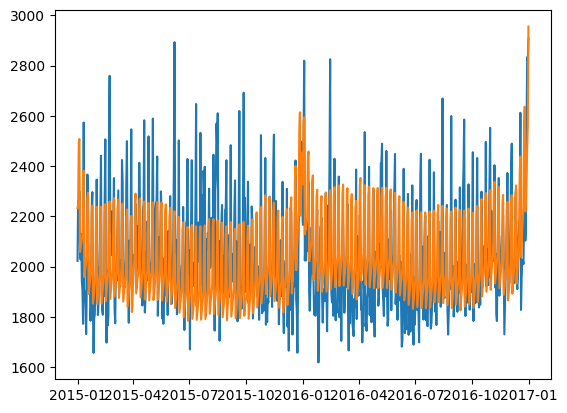

In [29]:
plt.plot(validation_dates, y_true_vals)
plt.plot(validation_dates, y_pred_vals)

plt.show()

### Final training

In [30]:
test_df = add_features(df=test_df)

2025-01-21 17:30:48.603 | INFO     | __main__:add_features:4 - Adding features
2025-01-21 17:30:48.625 | INFO     | __main__:add_features:8 - Adding basic time features
2025-01-21 17:30:48.634 | INFO     | __main__:add_features:15 - Adding week based features
2025-01-21 17:30:48.638 | INFO     | __main__:add_features:20 - Adding cyclical features
2025-01-21 17:30:48.689 | INFO     | __main__:add_features:45 - Adding one hot encoding features


In [31]:
X_train = train_df.drop(['id', 'date', 'num_sold'], axis=1)
y_train = np.log1p(train_df['num_sold'])

X_test = test_df.drop(['id', 'date'], axis=1)

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)
y_pred_transformed = np.expm1(y_pred)
test_df['num_sold'] = y_pred_transformed

In [32]:
submission_target = PROJECT_ROOT / 'data/submission.csv'

test_df[['id', 'num_sold']].to_csv(submission_target, index=False)